### Binary Classification Model for Kaggle Tabular Playground Series December 2021 Using Python and XGBoost
### David Lowe
### December 21, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground December 2021 dataset is a multi-class modeling situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The dataset used for this competition is synthetic but based on a real dataset and generated using a CTGAN. The dataset is used for this competition is synthetic, but based on a real dataset and generated using a CTGAN. This dataset is based off of the original Forest Cover Type Prediction competition.

ANALYSIS: The performance of the preliminary XGBoost model achieved an accuracy benchmark of 0.9590. After a series of tuning trials, the final model processed the training dataset with an accuracy score of 0.9613. When we processed the test dataset with the final model, the model achieved an accuracy score of 0.9546.

CONCLUSION: In this iteration, the XGBoost model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground 2021 December Data Set

Dataset ML Model: Multi-Class classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-dec-2021

One potential source of performance benchmark: https://www.kaggle.com/c/tabular-playground-series-dec-2021/leaderboard

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# # Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# # Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# # Mount Google Drive locally for loading the dotenv files
# from dotenv import load_dotenv
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

In [5]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 8


### 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
RNG_SEED = 88

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [8]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5

# Set default modeling scoring metric
SCORING_METRIC = 'accuracy'

# Define the directory locations and file names
TRAIN_DATASET = 'train.csv'
TEST_DATASET = 'test.csv'

In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [11]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021dec/train.csv

In [12]:
df_dataset_import = pd.read_csv(TRAIN_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   0       3189      40      8                                30   
1   1       3026     182      5                               280   
2   2       3106      13      7                               351   
3   3       3022     276     13                               192   
4   4       2906     186     13                               266   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                              13                             3270   
1                              29                             3270   
2                              37                             2914   
3                              16                             3034   
4                              22                             2916   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  Soil_Type32  \
0            206             234            193  ...            0   
1            233          

In [13]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 56 columns):
 #   Column                              Dtype
---  ------                              -----
 0   Id                                  int64
 1   Elevation                           int64
 2   Aspect                              int64
 3   Slope                               int64
 4   Horizontal_Distance_To_Hydrology    int64
 5   Vertical_Distance_To_Hydrology      int64
 6   Horizontal_Distance_To_Roadways     int64
 7   Hillshade_9am                       int64
 8   Hillshade_Noon                      int64
 9   Hillshade_3pm                       int64
 10  Horizontal_Distance_To_Fire_Points  int64
 11  Wilderness_Area1                    int64
 12  Wilderness_Area2                    int64
 13  Wilderness_Area3                    int64
 14  Wilderness_Area4                    int64
 15  Soil_Type1                          int64
 16  Soil_Type2                          

In [14]:
print(df_dataset_import.describe())

                 Id     Elevation        Aspect         Slope  \
count  4.000000e+06  4.000000e+06  4.000000e+06  4.000000e+06   
mean   2.000000e+06  2.980192e+03  1.515857e+02  1.509754e+01   
std    1.154701e+06  2.890482e+02  1.099611e+02  8.546731e+00   
min    0.000000e+00  1.773000e+03 -3.300000e+01 -3.000000e+00   
25%    9.999998e+05  2.760000e+03  6.000000e+01  9.000000e+00   
50%    2.000000e+06  2.966000e+03  1.230000e+02  1.400000e+01   
75%    2.999999e+06  3.217000e+03  2.470000e+02  2.000000e+01   
max    3.999999e+06  4.383000e+03  4.070000e+02  6.400000e+01   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      4.000000e+06                    4.000000e+06   
mean                       2.713154e+02                    5.166262e+01   
std                        2.265497e+02                    6.821597e+01   
min                       -9.200000e+01                   -3.170000e+02   
25%                        1.100000e+02

In [15]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Id                                    0
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0


In [16]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('Cover_Type').size())

Cover_Type
1    1468136
2    2262087
3     195712
4        377
5          1
6      11426
7      62261
dtype: int64


### 1.d) Data Cleaning

In [17]:
# Dropping features withunique values or no variations
df_dataset_import.drop(columns=['Id','Soil_Type7','Soil_Type15'], inplace=True)

#Dropping class with the least number of rows associated with
df_dataset_import = df_dataset_import[df_dataset_import['Cover_Type'] != 5]

# Convert columns from one data type to another
float_feature_list = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology',
                      'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways',
                      'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points']
for feature in float_feature_list:
    df_dataset_import[feature] = df_dataset_import[feature].astype('float')

# Standardize the class column to the name of target
df_dataset_import = df_dataset_import.rename(columns={'Cover_Type':'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0     3189.0    40.0    8.0                              30.0   
1     3026.0   182.0    5.0                             280.0   
2     3106.0    13.0    7.0                             351.0   
3     3022.0   276.0   13.0                             192.0   
4     2906.0   186.0   13.0                             266.0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                            13.0                           3270.0   
1                            29.0                           3270.0   
2                            37.0                           2914.0   
3                            16.0                           3034.0   
4                            22.0                           2916.0   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0          206.0           234.0          193.0   
1          233.0           240.0          106.0   
2          208.0           234.0   

In [18]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999999 entries, 0 to 3999999
Data columns (total 53 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   Elevation                           float64
 1   Aspect                              float64
 2   Slope                               float64
 3   Horizontal_Distance_To_Hydrology    float64
 4   Vertical_Distance_To_Hydrology      float64
 5   Horizontal_Distance_To_Roadways     float64
 6   Hillshade_9am                       float64
 7   Hillshade_Noon                      float64
 8   Hillshade_3pm                       float64
 9   Horizontal_Distance_To_Fire_Points  float64
 10  Wilderness_Area1                    int64  
 11  Wilderness_Area2                    int64  
 12  Wilderness_Area3                    int64  
 13  Wilderness_Area4                    int64  
 14  Soil_Type1                          int64  
 15  Soil_Type2                          int64  
 16  

In [19]:
print(df_dataset_import.describe())

          Elevation        Aspect         Slope  \
count  3.999999e+06  3.999999e+06  3.999999e+06   
mean   2.980192e+03  1.515857e+02  1.509753e+01   
std    2.890482e+02  1.099611e+02  8.546724e+00   
min    1.773000e+03 -3.300000e+01 -3.000000e+00   
25%    2.760000e+03  6.000000e+01  9.000000e+00   
50%    2.966000e+03  1.230000e+02  1.400000e+01   
75%    3.217000e+03  2.470000e+02  2.000000e+01   
max    4.383000e+03  4.070000e+02  6.400000e+01   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      3.999999e+06                    3.999999e+06   
mean                       2.713155e+02                    5.166261e+01   
std                        2.265497e+02                    6.821597e+01   
min                       -9.200000e+01                   -3.170000e+02   
25%                        1.100000e+02                    4.000000e+00   
50%                        2.130000e+02                    3.100000e+01   
75%            

In [20]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0
Soil_Type12                           0


In [21]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
1    1468136
2    2262087
3     195712
4        377
6      11426
7      62261
dtype: int64


### 1.e) Splitting Data into Sets

In [22]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (3999999, 53) df_features_train.shape: (3999999, 52) df_target_train.shape: (3999999,)


### 1.f) Set up the parameters for data visualization

In [23]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [24]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [25]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

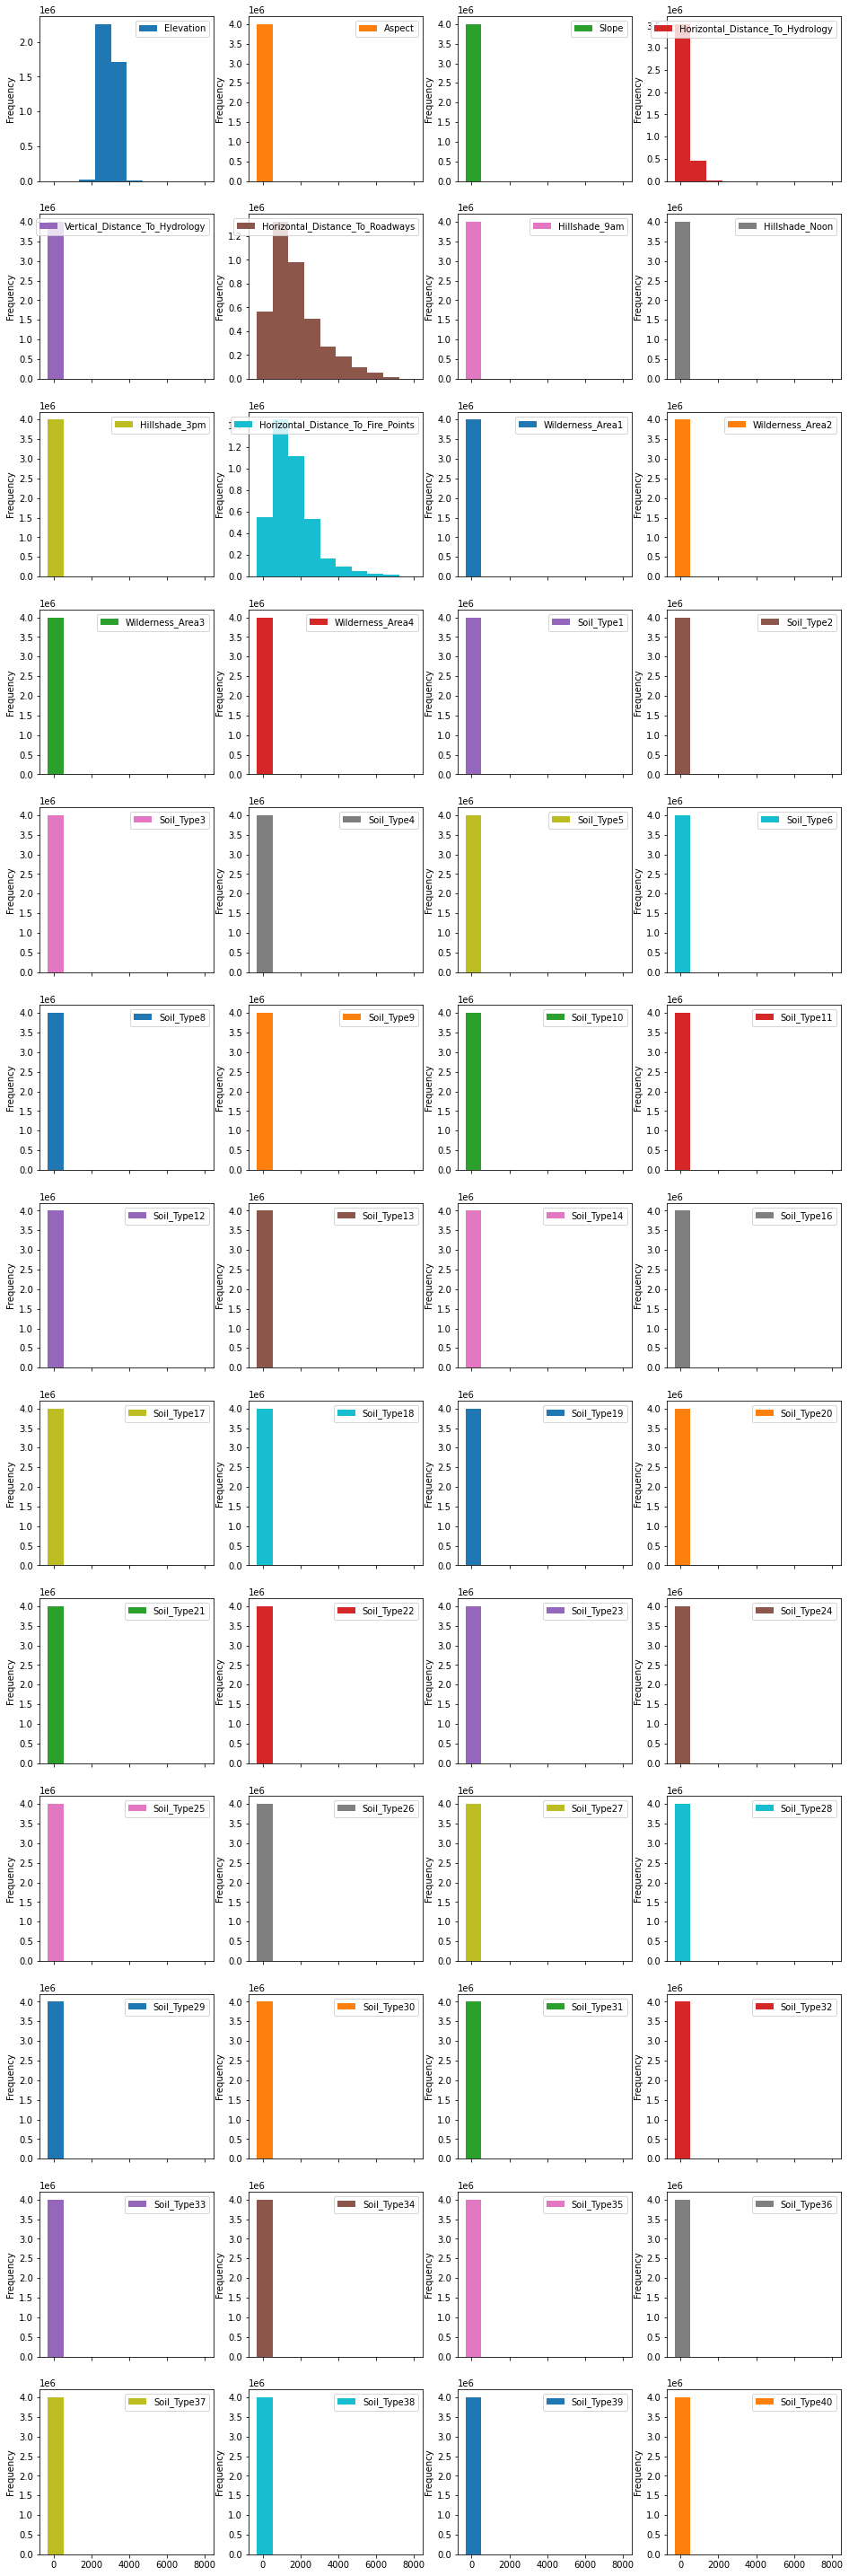

In [26]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

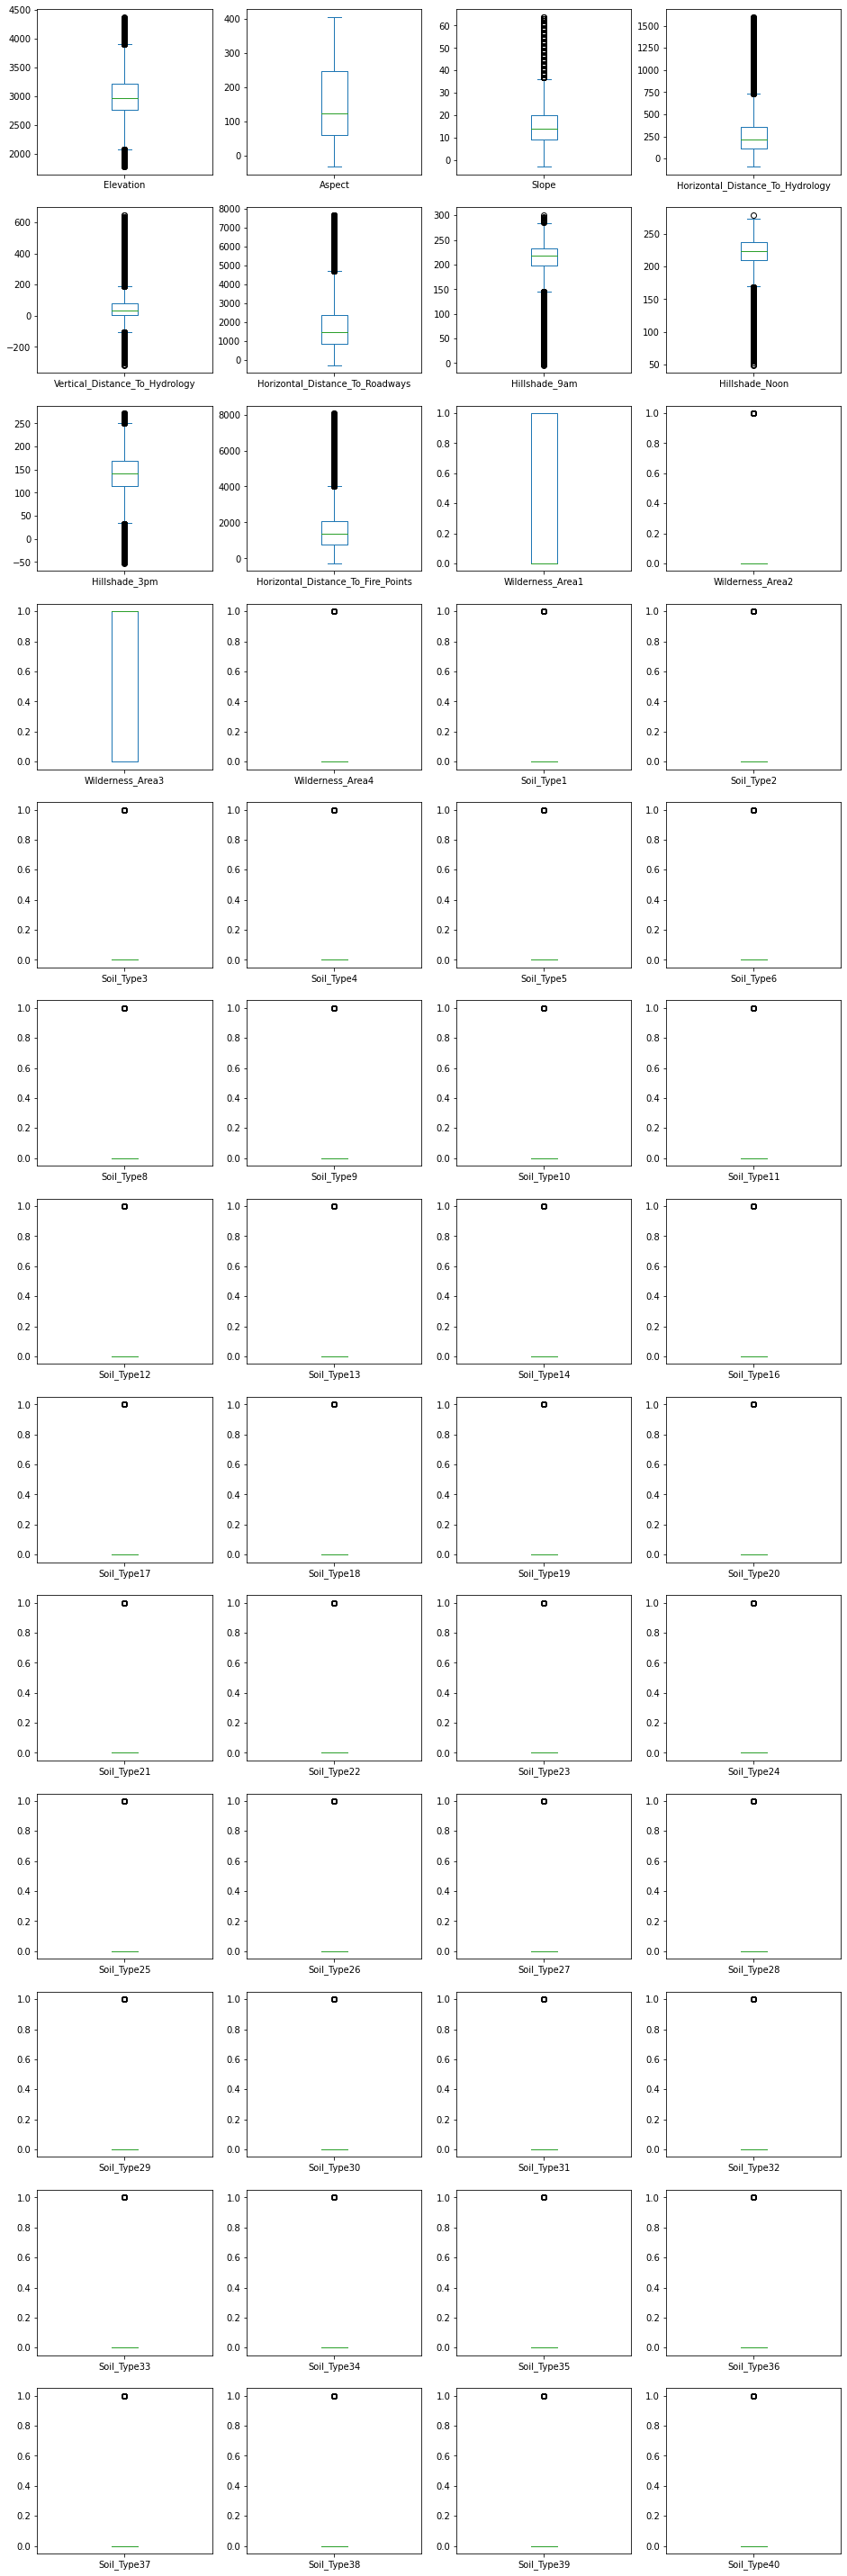

In [27]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

In [28]:
# # Correlation matrix
# fig = plt.figure(figsize=(20,20))
# ax = fig.add_subplot(111)
# correlations = df_features_train.corr(method='pearson')
# cax = ax.matshow(correlations, vmin=-1, vmax=1)
# fig.colorbar(cax)
# plt.show()

In [29]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [30]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [31]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 10
Number of categorical columns: 0
Total number of columns in the feature dataframe: 52


In [32]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
], remainder='passthrough')

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (3999999, 52) to array_features_train.shape: (3999999, 52)


### 3.b) Training Data Balancing

In [33]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [34]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [35]:
# Finalize the training dataset for the modeling activities
# array_features_train = df_features_train.to_numpy()
# array_target_train = df_target_train.ravel()
label_encoder = preprocessing.LabelEncoder()
array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (3999999, 52) array_target_train.shape: (3999999,)


In [36]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [37]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [38]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []

In [39]:
# train_models = [('XGB', XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss'))]
train_models = [('XGB', XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist'))]

In [40]:
# Generate model in turn
for name, model in train_models:
    if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
    start_time_module = datetime.now()
    kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
    cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
    train_results.append(cv_results)
    train_model_names.append(name)
    train_metrics.append(cv_results.mean())
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
    print(model)
    print ('Model training time:', (datetime.now() - start_time_module), '\n')
    if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:', np.mean(train_metrics))
print ('Total training time for all models:', (datetime.now() - start_time_training))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


XGB: 0.959034 (0.000055)
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='mlogloss', gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=2, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, random_state=88,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=None, tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=None, ...)
Model training time: 0:01:46.475856 

Average metrics (accuracy) from all models: 0.9590342397671747
Total training time for all models: 0:01:46.485639


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.8min finished


### 4.b) Algorithm Tuning

In [41]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [42]:
# Tuning XGBoost n_estimators, max_depth, and min_child_weight parameters
start_time_Module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# tune_model1 = XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss')
tune_model1 = XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')
tune_model_names.append('XGB_1')
paramGrid1 = dict(n_estimators=np.array([100, 300, 500]),
                  max_depth=np.array([3, 6, 9]),
                  min_child_weight=np.array([1, 2, 3]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_Module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.961263 using {'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 500}
0.947893 (0.000335) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
0.955972 (0.000121) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
0.957924 (0.000113) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}
0.947900 (0.000220) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100}
0.955959 (0.000270) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300}
0.957935 (0.000210) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 500}
0.947904 (0.000169) with: {'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100}
0.955950 (0.000186) with: {'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300}
0.957945 (0.000112) with: {'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500}
0.959034 (0.000055) with: {'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100}
0.961142 (0.000069) with: {'max_depth': 6, 'min_

In [43]:
BEST_MAX_DEPTH = grid_result1.best_params_['max_depth']
BEST_MIN_CHILD_WEIGHT = grid_result1.best_params_['min_child_weight']
BEST_N_ESTIMATORS = grid_result1.best_params_['n_estimators']
print('Best max_depth parameter:', BEST_MAX_DEPTH)
print('Best min_child_weight parameter:', BEST_MIN_CHILD_WEIGHT)
print('Best n_estimators parameter:', BEST_N_ESTIMATORS)

Best max_depth parameter: 6
Best min_child_weight parameter: 2
Best n_estimators parameter: 500


In [44]:
# Tuning XGBoost subsample and colsample_bytree parameters
start_time_Module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# tune_model2 = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
#                             random_state=RNG_SEED, n_jobs=N_JOBS, objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss')
tune_model2 = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            random_state=RNG_SEED, n_jobs=N_JOBS, objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')
tune_model_names.append('XGB_2')
paramGrid2 = dict(subsample=np.array([0.7, 0.8, 0.9, 1.0]),
                  colsample_bytree=np.array([0.7, 0.8, 0.9, 1.0]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_Module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best: 0.961300 using {'colsample_bytree': 0.7, 'subsample': 1.0}
0.960994 (0.000125) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
0.961171 (0.000096) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
0.961221 (0.000094) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
0.961300 (0.000111) with: {'colsample_bytree': 0.7, 'subsample': 1.0}
0.961086 (0.000186) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
0.961165 (0.000066) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
0.961204 (0.000108) with: {'colsample_bytree': 0.8, 'subsample': 0.9}
0.961220 (0.000140) with: {'colsample_bytree': 0.8, 'subsample': 1.0}
0.961033 (0.000112) with: {'colsample_bytree': 0.9, 'subsample': 0.7}
0.961129 (0.000113) with: {'colsample_bytree': 0.9, 'subsample': 0.8}
0.961160 (0.000129) with: {'colsample_bytree': 0.9, 'subsample': 0.9}
0.961281 (0.000114) with: {'colsample_bytree': 0.9, 'subsample': 1.0}
0.961033 (0.000161) with: {'colsam

In [45]:
BEST_COLSAMPLE_BYTREE = grid_result2.best_params_['colsample_bytree']
BEST_SUBSAMPLE = grid_result2.best_params_['subsample']
print('Best colsample_bytree parameter:', BEST_COLSAMPLE_BYTREE)
print('Best subsample parameter:', BEST_SUBSAMPLE)

Best colsample_bytree parameter: 0.7
Best subsample parameter: 1.0


### 4.c) Compare Algorithms After Tuning

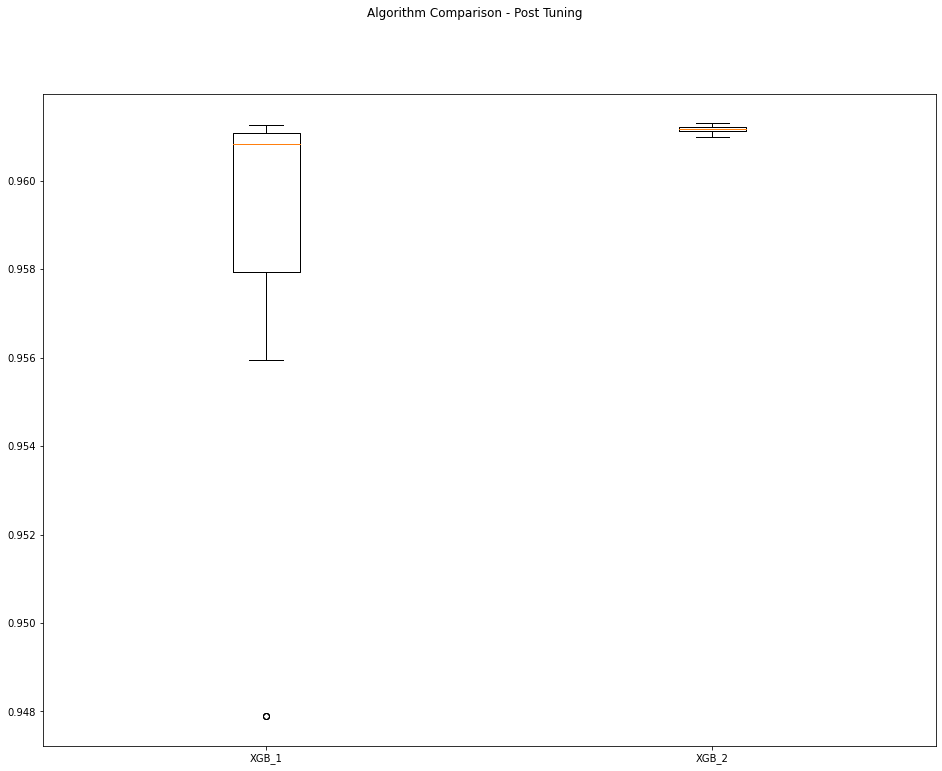

In [46]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [47]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [48]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Train the Final Model

In [49]:
# final_model = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
#                             colsample_bytree=BEST_COLSAMPLE_BYTREE, subsample=BEST_SUBSAMPLE,
#                             random_state=RNG_SEED, n_jobs=N_JOBS, objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss')
final_model = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            colsample_bytree=BEST_COLSAMPLE_BYTREE, subsample=BEST_SUBSAMPLE,
                            random_state=RNG_SEED, n_jobs=N_JOBS, objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')
final_model.fit(array_features_train, array_target_train)
print(final_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, eval_metric='mlogloss', gamma=0,
              gpu_id=0, importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=88,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1.0,
              tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, ...)


### 6.b) Load Test Dataset and Make Predictions

In [50]:
if not os.path.exists(TEST_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021dec/test.csv

--2021-12-21 05:04:27--  https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021dec/test.csv
Resolving dainesanalytics.com (dainesanalytics.com)... 99.86.189.76, 99.86.189.70, 99.86.189.127, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|99.86.189.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135209789 (129M) [text/csv]
Saving to: ‘test.csv’

test.csv            100%[===================>] 128.95M  37.1MB/s    in 3.5s    

2021-12-21 05:04:31 (37.1 MB/s) - ‘test.csv’ saved [135209789/135209789]



In [51]:
df_features_test = pd.read_csv(TEST_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

        Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0  4000000       2763      78     20                               377   
1  4000001       2826     153     11                               264   
2  4000002       2948      57     19                                56   
3  4000003       2926     119      6                               158   
4  4000004       2690      10      4                                38   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                              88                             3104   
1                              39                              295   
2                              44                              852   
3                             134                             2136   
4                             108                             3589   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  Soil_Type31  \
0            218             213            195  ...            0

In [52]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['Id'] = df_features_test['Id']
print(df_kaggle_submission.head())

        Id
0  4000000
1  4000001
2  4000002
3  4000003
4  4000004


In [53]:
# Dropping features
df_features_test.drop(columns=['Id'], inplace=True)

for feature in float_feature_list:
    df_features_test[feature] = df_features_test[feature].astype('float')

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0     2763.0    78.0   20.0                             377.0   
1     2826.0   153.0   11.0                             264.0   
2     2948.0    57.0   19.0                              56.0   
3     2926.0   119.0    6.0                             158.0   
4     2690.0    10.0    4.0                              38.0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                            88.0                           3104.0   
1                            39.0                            295.0   
2                            44.0                            852.0   
3                           134.0                           2136.0   
4                           108.0                           3589.0   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0          218.0           213.0          195.0   
1          219.0           238.0          148.0   
2          202.0           217.0   

In [54]:
# Finalize the test dataset for the modeling testing
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (1000000, 54) to array_features_test.shape: (1000000, 52)


In [55]:
# Make batched predictions
test_predictions = label_encoder.inverse_transform(final_model.predict(array_features_test))
print(test_predictions)

[2 2 2 ... 2 1 3]


In [56]:
df_kaggle_submission['Cover_Type'] = test_predictions
print(df_kaggle_submission.head())

        Id  Cover_Type
0  4000000           2
1  4000001           2
2  4000002           2
3  4000003           2
4  4000004           2


In [57]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20211221-0505.csv


In [58]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [59]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 4:21:55.080420
